# Import libraries

In [36]:
### import key libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import glob, os
from datetime import datetime as dt
from datetime import timedelta
from datetime import timezone
import pytz

In [37]:
### import Dask library (https://dask.org/)
import dask
import dask.dataframe as dd
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.distributed import Client

In [38]:
dask.__version__ ### tested using Dask version 1.1.4

'1.1.4'

In [39]:
from scipy import stats
from sklearn import cluster

In [40]:
### import scikit-mobility library
import skmob

In [41]:
### import geospatial libraries
import geopandas as gpd
import contextily as ctx
import pyproj

In [42]:
### import data4resilience toolkit 
from d4r_toolkit import data_preprocess
from d4r_toolkit import home_est
from d4r_toolkit import viz
from d4r_toolkit import utils

# Load data
## Set up Dask
* Notes:
    * Use **Dask** library for high-speed computation on edge computer
        * https://dask.org/
        * accumulates tasks and runs actual computation when ".compute()" is given
    * If cluster computing is available, using PySpark is recommended 
* Click the URL of the Dashboard below to monitor progress 

In [43]:
client = Client(n_workers=5) ### choose number of cores to use
client

Client Scheduler: tcp://127.0.0.1:59117 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 5 Memory: 10.47 GB


## Load data using Dask dataframes

In [44]:
### directory that contains dataset(s) you want to analyze
filepath = "D:/WB_Mexico/gpsdata_eq/testdata_all/"
toolkitpath = "C:/Users/yabec/PythonScripts/WB_Mexico/Toolkit/"
datapath = toolkitpath+"data/"
outpath  = toolkitpath+"results/"

### If the columns are unknown 

In [45]:
# data_preprocess.loaddata_takeapeek(filepath,",")

### load with column names

In [46]:
colnames = ["id","gaid","hw","lat","lon","accuracy","unixtime","noise"]

In [47]:
### loads all datasets in the directory into one dataframe
ddf = data_preprocess.loaddata(filepath, ",", colnames, "")

In [48]:
ddf.head()

,id,gaid,hw,lat,lon,accuracy,unixtime,noise
0,7153ee0768d7c0b829c87ba09f8a6750cef848614bc8d4...,GAID,NOMATCH,21.130271,-86.881452,3.443314,1507665266,25.204751
1,7153ee0768d7c0b829c87ba09f8a6750cef848614bc8d4...,GAID,NOMATCH,21.130410,-86.881489,0.000000,1507665266,25.204751
2,3a1bb47f20450d988b75c8cc915476d5291a7b24ff80eb...,GAID,NOMATCH,19.064921,-98.203577,0.000000,1507596133,32.439429
3,3a1bb47f20450d988b75c8cc915476d5291a7b24ff80eb...,GAID,NOMATCH,19.064542,-98.203620,0.000000,1507596133,32.439429
4,0527b7a89b30e63b23a2edd6b747104648aa5c6fb2b8ea...,GAID,NOMATCH,19.566999,-99.143749,0.000000,1507677576,43.176590


### quickly compute min/max of space-time  

In [44]:
%%time
dmin, dmax, lonmin, lonmax, latmin, latmax = dask.compute(ddf.unixtime.min(), 
                                                          ddf.unixtime.max(), 
                                                          ddf.lon.min(), ddf.lon.max(), 
                                                          ddf.lat.min(), ddf.lat.max()
                                                         )

Wall time: 8min 52s


In [45]:
print(data_preprocess.fromunix2fulldate(dmin), data_preprocess.fromunix2fulldate(dmax))
print(lonmin, lonmax, latmin, latmax)

2017-09-04 19:00:00 2017-10-10 18:59:59
-105.74974266557541 -86.57160846468355 14.628080638988493 22.54211336805097


In [46]:
boundary = (lonmin, latmin, lonmax, latmax)

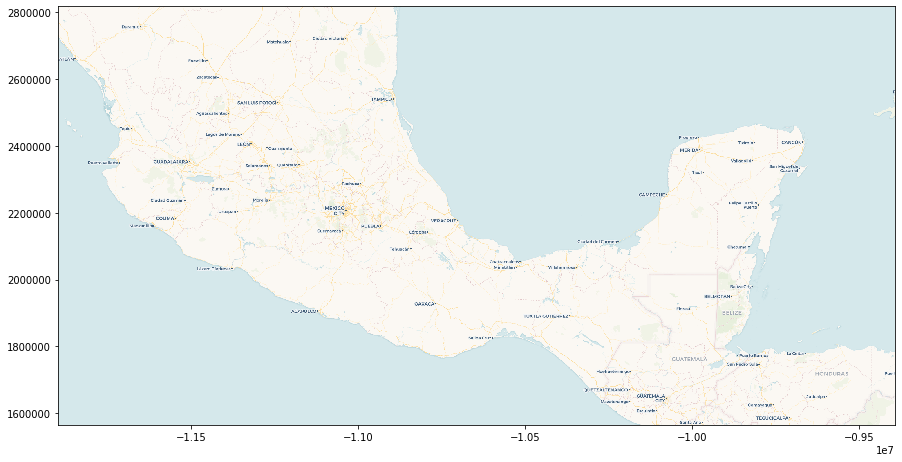

In [48]:
viz.visualize_boundarymap(boundary)

## Sample of dataset (choose a very small fraction) 

In [33]:
%%time
ddf_sample = ddf.sample(frac=0.0001).compute()

Wall time: 8min 7s


In [37]:
len(ddf_sample)

28244

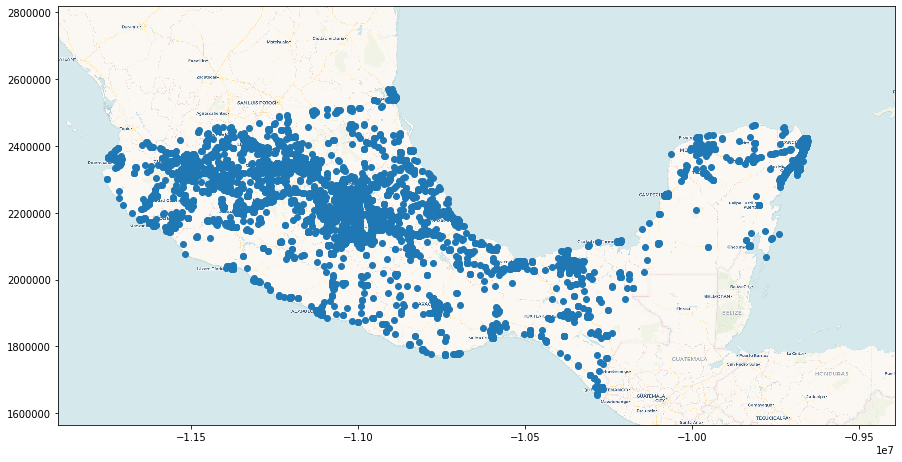

In [51]:
viz.visualize_simpleplot(ddf_sample)

# Clean data
* Some ideas on data cleaning:
    * **geographical boundary**; analyze data only within a specific area 
    * **temporal boundary**; analyze data only within a specific timeframe
    * **Users' data quality**; select users with more than X datapoints, etc.

## geographical boundary 

In [49]:
### define boundary box: (min long, min lat, max long, max lat)
# ==== Parameters === #
bbox = (-106.3, 15.5, -86.3, 29.1)

In [50]:
ddf_sc = ddf.map_partitions(data_preprocess.crop_spatial, bbox)

## temporal boundary

In [51]:
### define temporal cropping parameters (including these dates)
# ==== Parameters === #
timezone = "America/Mexico_City"
startdate = "2017/09/05"
enddate   = "2017/09/16"
nightendtime = "09:00:00"
nightstarttime = "18:00:00"

In [52]:
ddf_tc = ddf_sc.map_partitions(data_preprocess.crop_date, startdate, enddate, timezone)

In [53]:
ddf_tc2 = ddf_tc.map_partitions(data_preprocess.crop_time, nightendtime, nightstarttime, timezone)

## select users with sufficient data points
* **users_totalXpoints** : select users with more than X data points throughout entire period
* **users_Xdays** : select users with observations of more than X days
* **users_Xavgps** : select users with more than X observations per day 
* **users_Xdays_Xavgps** : select users that satisfy both criteria

In [62]:
# ==== Parameters === #
mindays = 3
avgpoints = 1

In [58]:
ddf_clean = ddf_tc2.map_partitions(data_preprocess.users_Xdays_Xavgps, mindays, avgpoints)
ddf_clean_homework = ddf_clean[ddf_clean["hw"]=="HOMEWORK"]

# Home location estimation
## estimation using Meanshift
* took ~ 2 hours 15 minutes for entire dataset (mindays=1, avgpoints=0.1)

In [60]:
%%time
id_home = ddf_clean.groupby("id").apply(home_est.meanshift).compute().reset_index().rename(columns={0:"home"})
print("Number of IDs with estimated homes: ",len(id_home))

In [31]:
### save to csv file
# id_home.to_csv(outpath+"id_home_"+str(mindays)+"_"+str(avgpoints).replace(".","")+".csv")

In [82]:
id_home = pd.read_csv(outpath+"id_home_"+str(mindays)+"_"+str(avgpoints).replace(".","")+".csv",sep=",")

In [84]:
id_home["lon"] = id_home["home"].apply(lambda x : x.split()[0].replace("[",""))
id_home["lat"] = id_home["home"].apply(lambda x : x.split()[1].replace("]",""))
id_home = id_home.drop(columns=["home"])[["id","lon","lat"]]
id_home.lon = id_home.lon.astype("float64")
id_home.lat = id_home.lat.astype("float64")
id_home.head()

,id,lon,lat
0,0170c200bddd3d91357c2157f52359846f476444008651...,-103.41117652,20.7113464
1,01a571727029a3f1cbc79aaa15e4ada2295ba53b80f861...,-99.13665454,19.65897126
2,0275beee9aa5d924a822773297fc2296de7393c44aed99...,-100.81493232,20.50570084
3,031d901445bc3f539231ae0d8edf3d556031f90345ec3c...,-98.28767735,19.07538431
4,03f5f4251c53efda91a4346fef999e8e6139130c92aac7...,-97.866598,22.23679558


In [91]:
idhome_gdf = gpd.GeoDataFrame(id_home, geometry=gpd.points_from_xy(id_home.lon, id_home.lat))

## compute administrative region for each ID
### manzana shape data (for only urban areas) 

In [92]:
### load shape data
areas = ["09_Manzanas_INV2016_shp","17_Manzanas_INV2016_shp",
         "21_Manzanas_INV2016_shp","29_Manzanas_INV2016_shp"]
manz_shp = gpd.GeoDataFrame()
for i,a in enumerate(areas):
    manz_f = datapath+"spatial/manzanas_shapefiles/"+a+"/"
    manz_shp1 = gpd.read_file(manz_f)
    manz_shp = manz_shp.append(manz_shp1, ignore_index=True)
    print("done",i)

done 0
done 1
done 2
done 3


In [93]:
manz_shp = manz_shp[["geometry","CVEGEO",'ENT','MUN','LOC','AGEB', 'MZA']]
manz_shp.head()

,geometry,CVEGEO,ENT,MUN,LOC,AGEB,MZA
0,"POLYGON ((-99.20644 19.51393, -99.20640 19.513...",0900200010010001,09,002,0001,0010,001
1,"POLYGON ((-99.20594 19.51418, -99.20586 19.514...",0900200010010002,09,002,0001,0010,002
2,"POLYGON ((-99.20526 19.51279, -99.20526 19.512...",0900200010010003,09,002,0001,0010,003
3,"POLYGON ((-99.20563 19.51279, -99.20562 19.512...",0900200010010004,09,002,0001,0010,004
4,"POLYGON ((-99.20655 19.51278, -99.20653 19.512...",0900200010010005,09,002,0001,0010,005


### entidad, municipio data

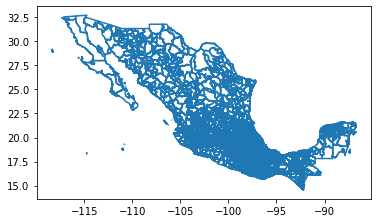

In [94]:
adm2_f = datapath+"spatial/boundaries_shapefiles/mex_admbnda_adm2_govmex/"
adm2_shp = gpd.read_file(adm2_f)
adm2_shp.boundary.plot()

In [95]:
adm2_shp = adm2_shp[["ADM2_PCODE","geometry"]]
adm2_shp["ent"] = adm2_shp["ADM2_PCODE"].apply(lambda x : x[2:4])
adm2_shp["entmun"] = adm2_shp["ADM2_PCODE"].apply(lambda x : x[2:])

In [96]:
adm2_shp.head()

,ADM2_PCODE,geometry,ent,entmun
0,MX01001,"POLYGON ((-102.09775 22.02325, -102.09857 22.0...",01,01001
1,MX01002,"POLYGON ((-101.99941 22.21951, -101.99940 22.2...",01,01002
2,MX01003,"POLYGON ((-102.57625 21.96778, -102.57626 21.9...",01,01003
3,MX01004,"POLYGON ((-102.25320 22.37449, -102.25239 22.3...",01,01004
4,MX01005,"POLYGON ((-102.31034 22.03716, -102.30653 22.0...",01,01005


## Spatial join
* compute what geographical boundar each home location is in

### mobile phone data s-join with manzana data

In [97]:
id_manz = gpd.sjoin(idhome_gdf, manz_shp, how="inner", op='within')
id_manz["loc_code"]  = id_manz["CVEGEO"].apply(lambda x : x[:9])
id_manz["ageb_code"] = id_manz["CVEGEO"].apply(lambda x : x[:13])
id_manz["mza_code"]  = id_manz["CVEGEO"].apply(lambda x : x[:16])
id_manz = id_manz.drop(columns=["LOC","AGEB","MZA"])
id_manz.head()

C:\Users\yabec\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


,id,lon,lat,geometry,index_right,CVEGEO,ENT,MUN,loc_code,ageb_code,mza_code
11,07d4f845df6a1c18b41df9747d55e80a7ae47f20b5539d...,-99.211935,19.382676,POINT (-99.21193 19.38268),40043,0901000011523025,09,010,090100001,0901000011523,0901000011523025
28590,1ce7b93150bf4a22efb2e174835e8f4c3140fb97e0607f...,-99.212414,19.382569,POINT (-99.21241 19.38257),40043,0901000011523025,09,010,090100001,0901000011523,0901000011523025
48053,a439dd45565586d99c6b6b3fbba2487e57160aacb42164...,-99.212089,19.382772,POINT (-99.21209 19.38277),40043,0901000011523025,09,010,090100001,0901000011523,0901000011523025
95640,0c107e4d69fd368f4dd463f1ed2c0cc7ec18b01fd21563...,-99.211811,19.382773,POINT (-99.21181 19.38277),40043,0901000011523025,09,010,090100001,0901000011523,0901000011523025
157932,210f947b2189c8098b870ab921d72b556325a7b33e529b...,-99.212715,19.382532,POINT (-99.21271 19.38253),40043,0901000011523025,09,010,090100001,0901000011523,0901000011523025


### mobile phone data s-join with entidad/muncipio data

In [98]:
id_entmun = gpd.sjoin(idhome_gdf, adm2_shp, how="inner", op='within')
id_entmun.head()

C:\Users\yabec\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


,id,lon,lat,geometry,index_right,ADM2_PCODE,ent,entmun
0,0170c200bddd3d91357c2157f52359846f476444008651...,-103.411177,20.711346,POINT (-103.41118 20.71135),650,MX14120,14,14120
14,09247cd75b6a43bac8e29e68ad2999420667d2ebabf819...,-103.397711,20.636225,POINT (-103.39771 20.63622),650,MX14120,14,14120
15,096412f7bfba8d944852b568da5db61baac46b0f69cd29...,-103.442888,20.624073,POINT (-103.44289 20.62407),650,MX14120,14,14120
77,3ea3e62483509db5b1837f0c05f31741e7530938dc5dd9...,-103.438550,20.726962,POINT (-103.43855 20.72696),650,MX14120,14,14120
108,598d4660a57d45fbf261a2a0224b9efb2121eaa76aacd9...,-103.397408,20.765388,POINT (-103.39741 20.76539),650,MX14120,14,14120


# Validation using census population data
## population data for all levels

In [99]:
poppath = datapath+"sociodemographic/populationdata/"
df_pop = pd.DataFrame()
for es in ["09","17","21","29"]:
    pop = poppath+"resultados_ageb_urbana_"+es+"_cpv2010.csv"
    df_pop1 = pd.read_csv(pop)[["entidad","mun","loc","ageb","mza","pobtot"]]
    df_pop = df_pop.append(df_pop1, ignore_index=True)
    
df_pop["CVEGEO"] = df_pop.apply(lambda row: str(row["entidad"]).zfill(2)+
                                str(row["mun"]).zfill(3)+
                                str(row["loc"]).zfill(4)+
                                str(row["ageb"]).zfill(4)+
                                str(row["mza"]).zfill(3), axis=1)

In [100]:
df_pop.head()

,entidad,mun,loc,ageb,mza,pobtot,CVEGEO
0,9,0,0,0000,0,8851080,0900000000000000
1,9,2,0,0000,0,414711,0900200000000000
2,9,2,1,0000,0,414711,0900200010000000
3,9,2,1,0010,0,3424,0900200010010000
4,9,2,1,0010,1,202,0900200010010001


### Entidad level

In [101]:
ent_ids = id_entmun.groupby("ent").id.count().reset_index()
ent_pop = df_pop[(df_pop["mun"]==0) & (df_pop["loc"]==0) 
                 & (df_pop["ageb"]=="0000") & (df_pop["mza"]==0)][["entidad","pobtot"]]
ent_pop["ent"] = ent_pop["entidad"].apply(lambda x : str(x).zfill(2))
ent_ids_pop = ent_pop.merge(ent_ids, on="ent")

### Municipio level

In [102]:
mun_ids = id_entmun.groupby("entmun").id.count().reset_index()
mun_pop = df_pop[(df_pop["mun"]!=0) & (df_pop["loc"]==0) 
                 & (df_pop["ageb"]=="0000") & (df_pop["mza"]==0)][["CVEGEO","pobtot"]]
mun_pop["entmun"] = mun_pop["CVEGEO"].apply(lambda x : str(x)[:5])
mun_ids_pop = mun_pop.merge(mun_ids, on="entmun")

### Localidades level

In [103]:
loc_ids = id_manz.groupby("loc_code").id.count().reset_index()
loc_pop = df_pop[(df_pop["mun"]!=0) & (df_pop["loc"]!=0) 
                 & (df_pop["ageb"]=="0000") & (df_pop["mza"]==0)][["CVEGEO","pobtot"]]
loc_pop["loc_code"] = loc_pop["CVEGEO"].apply(lambda x : str(x)[:9])
loc_ids_pop = loc_pop.merge(loc_ids, on="loc_code")

### AGEB level

In [104]:
ageb_ids = id_manz.groupby("ageb_code").id.count().reset_index()
ageb_pop = df_pop[(df_pop["mun"]!=0) & (df_pop["loc"]!=0) 
                 & (df_pop["ageb"]!="0000") & (df_pop["mza"]==0)][["CVEGEO","pobtot"]]
ageb_pop["ageb_code"] = ageb_pop["CVEGEO"].apply(lambda x : str(x)[:13])
ageb_ids_pop = ageb_pop.merge(ageb_ids, on="ageb_code")

### Manzana level

In [105]:
mza_ids = id_manz.groupby("mza_code").id.count().reset_index()
mza_pop = df_pop[(df_pop["mun"]!=0) & (df_pop["loc"]!=0) 
                 & (df_pop["ageb"]!="0000") & (df_pop["mza"]!=0)][["CVEGEO","pobtot"]]
mza_pop["mza_code"] = mza_pop["CVEGEO"].apply(lambda x : str(x)[:17])
mza_ids_pop = mza_pop.merge(mza_ids, on="mza_code")

## plot census population vs MP data

In [106]:
def plot_compare(df, ax, title):
    df["logpop"] = np.log10(df["pobtot"])
    df["loguser"] = np.log10(df["id"])        
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
#     for col in set(df["color"].values):
#         df_thiscol = df[df["color"]==col]
    ax.scatter(df["logpop"].values, df["loguser"].values, color="b", s=15)
    c1, i1, s1, p_value, std_err = stats.linregress(df["logpop"].values, df["loguser"].values)
    ax.plot([0,np.max(df["logpop"])*1.1],[i1,i1+np.max(df["logpop"])*1.1*c1], 
            linestyle="-", color="gray")   
    ax.set_xlim(np.min(df["logpop"]),np.max(df["logpop"])*1.1)
    ax.set_ylim(0,np.max(df["loguser"])*1.1)
    ax.set_xlabel(r"$log_{10}$(Census population)", fontsize=14)
    ax.set_ylabel(r"$log_{10}$(Unique users)", fontsize=14)
    ax.annotate("Slope: "+str(c1)[:5]+"\n"+str(s1)[:5]+utils.stars(p_value), 
                        xy=(.1,0.7), 
                        xycoords='axes fraction', color="k", fontsize=14)
    ax.set_title(title, fontsize=16)

C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


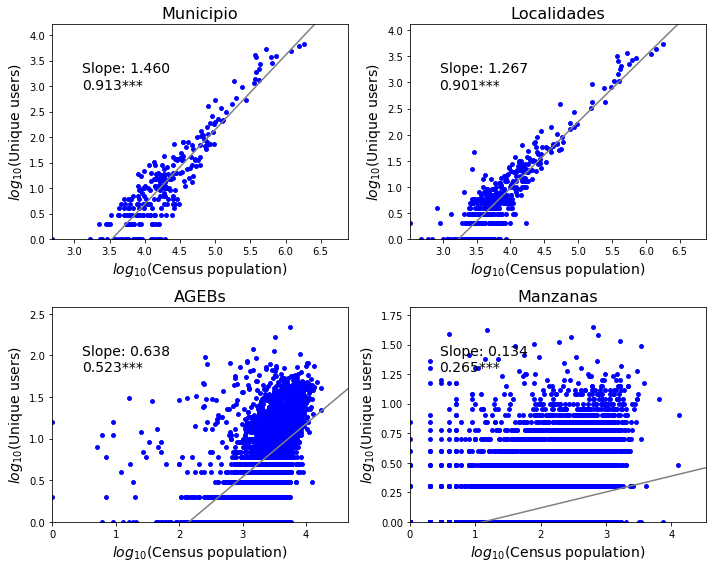

In [107]:
fig = plt.figure(figsize=(10,8))
gs=GridSpec(2,2)

ax0 = fig.add_subplot(gs[0,0]) 
plot_compare(mun_ids_pop, ax0, "Municipio")

ax1 = fig.add_subplot(gs[0,1]) 
plot_compare(loc_ids_pop, ax1, "Localidades")

ax2 = fig.add_subplot(gs[1,0]) 
plot_compare(ageb_ids_pop, ax2, "AGEBs")

ax3 = fig.add_subplot(gs[1,1]) 
plot_compare(mza_ids_pop, ax3, "Manzanas")

plt.tight_layout()
# plt.savefig(outpath+"represent_manzana_eq.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()